## Trading a Delta Hedged Straddle

**_Please go through the "building strategies" notebook before looking at this notebook._**

Let's trade some delta hedged Pepsi (PEP) straddles.

1.  We will buy 10 contracts of a Put and a Call at the strike that is closest to the underlying stock price 
and hedge any remaining delta with underlying stock.
2.  We will buy and sell the expiry that is closest to today but at least 5 trading days out.
3.  We will exit the trade and its hedge one day after we enter it.
4.  We will exit the trade after 3:30 pm NY time 
5.  We assume no slippage (entry and exit at mid price) and commission of 1/2 a cent for stock trades and 1 dollar }for option trades

This is an illustrative example.  In real life you would add code for error handling, make more reasonable assumptions on slippage, margin and also deal with missing data.

First lets generate some option prices based on the underlying stock price.  We will generate some random volatility numbers, and use Black Scholes to generate prices.  We will add all this data to a strategy context that we can later use from our strategy and avoid excessive global variables.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import os
from types import SimpleNamespace

import pyqstrat as pq

pq.set_defaults() # Set some display defaults to make dataframes and plots easier to look at

try:
    file_path = os.path.dirname(os.path.realpath(__file__)) + '/../notebooks/support/pepsi_15_min_prices.csv.gz' # If we are running from unit tests
except:
    file_path = '../notebooks/support/pepsi_15_min_prices.csv.gz'
    
prices = pd.read_csv(file_path)
prices.date = pd.to_datetime(prices.date)

strategy_context = SimpleNamespace()

timestamps = prices.date.values.astype('M8[s]')
close_prices = prices.c.values

strategy_context.timestamps = timestamps
strategy_context.close_prices = close_prices

calendar = pq.Calendar.get_calendar(pq.Calendar.NYSE)
strategy_context.calendar = calendar
stock_symbol = 'PEP'
strategy_context.stock_symbol = stock_symbol

In [2]:
# Generate the same random values each time we run this notebook
np.random.seed(0)

# Generate random implied vol numbers from 10% to 15%
implied_vol = np.random.rand(len(prices)) * 0.05 + 0.10

# Generate strikes and expiries
strikes = np.arange(prices.c.min() - 20, prices.c.max() + 20, 5)
# Round strikes down to the nearest $5
strikes = np.round(strikes / 5) * 5
strategy_context.strikes = strikes

# Generate expiries 1 month (21 trading days) and 2 months (42 trading days) away from first date we have prices for
expiries = np.array([calendar.add_trading_days(timestamps.min(), 21), calendar.add_trading_days(timestamps.min(), 42)])
strategy_context.expiries = expiries

# Now lets generate options
option_prices = {}
stock_prices = {}
option_deltas = {}

for i, timestamp in enumerate(timestamps):
    close_price = close_prices[i]
    for expiry in expiries:
        expiry_month = expiry.astype(object).month
        t = (expiry - timestamp) / np.timedelta64(1, 'D') / 365.0  # Time to expiry as fraction of a year
        for strike in strikes:
            for put_call in ['P', 'C']:
                option_symbol = f'PEP_{expiry_month}:{put_call}:{strike:.0f}'
                option_price = pq.black_scholes_price((put_call == 'C'), S = close_price, K = strike, t = t, r = 0.02, sigma = implied_vol[i], q = 0)
                option_prices[(option_symbol, timestamp)] = option_price
                delta = pq.delta((put_call == 'C'), S = close_price, K = strike, t = t, r = 0.02, sigma = implied_vol[i], q = 0)
                option_deltas[(option_symbol, timestamp)] = delta

# Also store underlying prices in a dict for easy retrieval later
for i, timestamp in enumerate(timestamps):
    stock_prices[timestamp] = close_prices[i]
    
strategy_context.stock_prices = stock_prices
strategy_context.option_prices = option_prices
strategy_context.option_deltas = option_deltas


Lets create functions that we can use to get the price of any option or the underlying given a symbol and timestamp

In [3]:
def get_option_price(option_symbol, timestamp, context):
    option_prices = context.option_prices
    return option_prices.get((option_symbol, timestamp))

def get_stock_price(symbol, timestamp, context):
    stock_prices = context.stock_prices
    return stock_prices.get(timestamp)

def get_price(contract, timestamps, i, context):
    timestamp = timestamps[i]
    contract_type = contract.properties.contract_type
    if contract_type == "Option":
        return get_option_price(contract.symbol, timestamp, context)
    elif contract_type == "Stock":
        return get_stock_price(contract.symbol, timestamp, context)
    else:
        assert False, f'unknown contract type: {contract}'

Let's say we want to buy the straddles when implied vol is below 14% and sell after one trading day.  We will trade the closest expiry that is at least one week out from today.  We will get out at the end of the trading day, after 3:30 PM NY time.  Lets create indicators, signals and entry, exit rules

In [4]:
class OrderCodes:
    '''
    Convenience class to group order reason code constants
    '''
    ENTER_OPTION = 'ENTER_OPTION'
    EXIT_OPTION  = 'EXIT_OPTION'
    ENTER_HEDGE  = 'ENTER_HEDGE'
    EXIT_HEDGE   = 'EXIT_HEDGE'

def straddle_entry_signal(contract_group, timestamps, indicators, parent_signals, context):
    return indicators.implied_vol < 0.11

def straddle_exit_signal(contract_group, timestamps, indicators, parent_signals, context):
    date = timestamps.astype('M8[D]')
    time = (timestamps - date) / np.timedelta64(1, 'm') # Minutes since midnight
    signal = time > 15 * 60 + 30 # 3:30 pm in minutes
    return signal
    
def straddle_entry_rule(contract_group, i, timestamps, indicators, signal, account, context):
    expiries, strikes, option_deltas = context.expiries, context.strikes, context.option_deltas
    hedge_contract_group, calendar = context.hedge_contract_group, context.calendar
    
    timestamp = timestamps[i]
    
    straddle_exit_time = context.straddle_exit_time
    
    if straddle_exit_time is not None and (timestamp - straddle_exit_time) / np.timedelta64(1, 'D') < 1:
        # Don't enter a straddle on the same day we exited
        return []
    
    # Find the expiry we want to trade
    max_expiry = calendar.add_trading_days(timestamp, 5) # At least 5 trading days out
    expiry = expiries[np.searchsorted(expiries, max_expiry)] # Closest expiry at least trading days 5 days out
    
    # Find the strike we want to trade
    stock_price = indicators.close_price[i]
    strike = strikes[pq.np_find_closest(strikes, stock_price)]
    
    expiry_month = expiry.astype(datetime.datetime).month

    call_symbol = f'PEP_{expiry_month}:C:{strike:.0f}'
    put_symbol = f'PEP_{expiry_month}:P:{strike:.0f}'
    
    call_contract = contract_group.get_contract(call_symbol)
    put_contract = contract_group.get_contract(put_symbol)
    
    opt_properties = SimpleNamespace(contract_type = 'Option', strike = strike)

    if call_contract is None: call_contract = pq.Contract.create(call_symbol, contract_group, expiry, 100, opt_properties)
    if put_contract is None:  put_contract =  pq.Contract.create(put_symbol,  contract_group, expiry, 100, opt_properties)
        
    # Record implied vol at order time so we can look at whether implied vol fell by the time we exited
    implied_vol =  indicators.implied_vol[i]
        
    order_properties = SimpleNamespace(implied_vol = implied_vol)
   
    call_order = pq.MarketOrder(call_contract, timestamp, 10, reason_code = OrderCodes.ENTER_OPTION, properties = order_properties)
    put_order =  pq.MarketOrder(put_contract,  timestamp, 10, reason_code = OrderCodes.ENTER_OPTION, properties = order_properties)
    
    call_delta = option_deltas[(call_symbol, timestamp)]
    put_delta = option_deltas[(put_symbol, timestamp)]
    
    delta = call_delta + put_delta
    
    hedge_contract = hedge_contract_group.get_contract(stock_symbol)
    hedge_properties = SimpleNamespace(contract_type = 'Stock')
    if hedge_contract is None: hedge_contract = pq.Contract.create(stock_symbol, contract_group = hedge_contract_group, properties = hedge_properties)
    hedge_qty = round(-100 * delta)
    if hedge_qty != 0:
        hedge_order = pq.MarketOrder(hedge_contract, timestamp, hedge_qty, reason_code = OrderCodes.ENTER_HEDGE, properties = order_properties)
    else:
        hedge_order = None
        
    orders = [call_order, put_order]
    if hedge_order: orders.append(hedge_order)
    
    msg = f'\nEntering straddle: {timestamp}: '
    for order in orders:
        strike_str = f' strike: {order.contract.properties.strike:.0f}' if order.contract.properties.contract_type == 'Option' else ''
        msg += f'\n   {order.contract.symbol} qty: {order.qty:.0f}{strike_str} vol: {implied_vol:.4f} reason: {order.reason_code}'
    print(msg)
    
    return orders

def straddle_exit_rule(contract_group, i, timestamps, indicators, signal, account, context):
    timestamp = timestamps[i]
    orders = []
    
    straddle_entry_time = context.straddle_entry_time
    
    if straddle_entry_time is not None and (timestamp - straddle_entry_time) / np.timedelta64(1, 'D') < 1:
        # We have not held the straddle for one day yet, so don't exit
        return []
    
    positions = account.positions(contract_group, timestamp)
    
    if len(positions) > 3:
        assert False, f'{i} {timestamp} {positions} {contract_group}'
    
    # Record implied vol at order time so we can look at whether implied vol fell by the time we exited
    implied_vol =  indicators.implied_vol[i]
        
    order_properties = SimpleNamespace(implied_vol = implied_vol)
    
    for contract, qty in positions:
        if contract.properties.contract_type == 'Option':
            reason_code = OrderCodes.EXIT_OPTION
        else:
            reason_code = OrderCodes.EXIT_HEDGE
            
        order = pq.MarketOrder(contract, timestamp, -qty, reason_code, properties = order_properties)
        orders.append(order)
        
    msg = f'\nExiting straddle: {timestamp}: '
    for order in orders:
        strike_str = f' strike: {order.contract.properties.strike:.0f}' if order.contract.properties.contract_type == 'Option' else ''
        msg += f'\n   {order.contract.symbol} qty: {order.qty:.0f}{strike_str} vol: {implied_vol:.4f} reason: {order.reason_code}'
    print(msg)
 
        
    return orders

def market_simulator(orders, i, timestamps, indicators, signals, context):
    timestamp = timestamps[i]
    if not len(orders): return []

    trades = []
    
    # Assume no slippage, i.e. we get filled at mid
    # Assume 1/2 cent commission for stock, $1 commission per contract for option
    for order in orders:
        contract = order.contract
        contract_type = contract.properties.contract_type
        if contract_type == 'Option':
            trade_price = get_option_price(contract.symbol, timestamp, context)
            commission = 0.005 * abs(order.qty)
        else:
            trade_price = get_stock_price(contract.symbol, timestamp, context)
            commission = abs(order.qty)
        trade = pq.Trade(order.contract, timestamp, order.qty, trade_price, order = order, commission = commission)
        trades.append(trade)
        
    if trades[0].qty > 0: # We are entering the straddle so record entry time
        context.straddle_entry_time = timestamp
        context.straddle_exit_time = None
    else:
        context.straddle_entry_time = None
        context.straddle_exit_time = timestamp
        
    msg = f'\nTrades: {timestamp}: '
    for trade in trades:
        msg += f'\n   {trade.order.contract.symbol} qty: {trade.qty} price: {trade.price:.2f} commission: {trade.commission:.2f}'
    print(msg)
    
    for trade in trades:
        trade.order.status = pq.OrderStatus.FILLED

    return trades

def dummy_simulator(orders, i, timestamps, indicators, signals, context):
    return []


In [5]:
if __name__ == "__main__":
    # Clear global state so we can rerun without restarting python
    pq.ContractGroup.clear()
    pq.Contract.clear()
    
    straddle_contract_group = pq.ContractGroup.create('Straddle')
    hedge_contract_group = pq.ContractGroup.create('Hedge')
    
    strategy_context.straddle_entry_time = None
    strategy_context.straddle_exit_time = None
    strategy_context.hedge_contract_group = hedge_contract_group
  
    strategy = pq.Strategy(timestamps = timestamps, 
                           contract_groups = [straddle_contract_group, hedge_contract_group],
                           price_function = get_price,
                           strategy_context = strategy_context,
                           starting_equity = 1e7)
    

    strategy.add_indicator('close_price', close_prices, contract_groups = [straddle_contract_group])
    strategy.add_indicator('implied_vol', implied_vol, contract_groups = [straddle_contract_group])
            
    strategy.add_signal('straddle_entry', straddle_entry_signal, contract_groups = [straddle_contract_group], depends_on_indicators = ['implied_vol'])
    strategy.add_signal('straddle_exit', straddle_exit_signal, contract_groups = [straddle_contract_group])

    strategy.add_rule('straddle_entry', straddle_entry_rule, signal_name = 'straddle_entry', position_filter = 'zero')
    strategy.add_rule('straddle_exit', straddle_exit_rule, signal_name = 'straddle_exit', position_filter = 'nonzero')
    strategy.add_market_sim(market_simulator, contract_groups = [straddle_contract_group])
    
    strategy.add_market_sim(dummy_simulator, contract_groups = [hedge_contract_group])
    
    strategy.run()


Entering straddle: 2019-01-14T13:15:00: 
   PEP_2:C:105 qty: 10 strike: 105 vol: 0.1036 reason: ENTER_OPTION
   PEP_2:P:105 qty: 10 strike: 105 vol: 0.1036 reason: ENTER_OPTION
   PEP qty: -60 vol: 0.1036 reason: ENTER_HEDGE

Trades: 2019-01-14T13:30:00: 
   PEP_2:C:105 qty: 10 price: 3.05 commission: 0.05
   PEP_2:P:105 qty: 10 price: 0.35 commission: 0.05
   PEP qty: -60 price: 107.53 commission: 60.00

Exiting straddle: 2019-01-15T15:45:00: 
   PEP_2:C:105 qty: -10 strike: 105 vol: 0.1285 reason: EXIT_OPTION
   PEP_2:P:105 qty: -10 strike: 105 vol: 0.1285 reason: EXIT_OPTION

Trades: 2019-01-15T16:00:00: 
   PEP_2:C:105 qty: -10 price: 4.38 commission: 0.05
   PEP_2:P:105 qty: -10 price: 0.23 commission: 0.05

Entering straddle: 2019-01-16T16:00:00: 
   PEP_2:C:110 qty: 10 strike: 110 vol: 0.1060 reason: ENTER_OPTION
   PEP_2:P:110 qty: 10 strike: 110 vol: 0.1060 reason: ENTER_OPTION
   PEP qty: 35 vol: 0.1060 reason: ENTER_HEDGE

Trades: 2019-01-17T09:45:00: 
   PEP_2:C:110 qty: 1

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019
,0.001389,5.508e-06,4.287e-05,2.04,3.861,-9.983,-9.983,-0.0001391,2019-01-22/2019-01-30,-0.0001391,2019-01-22/2019-01-30,15/14/0.517,0.001389


<Figure size 432x288 with 0 Axes>

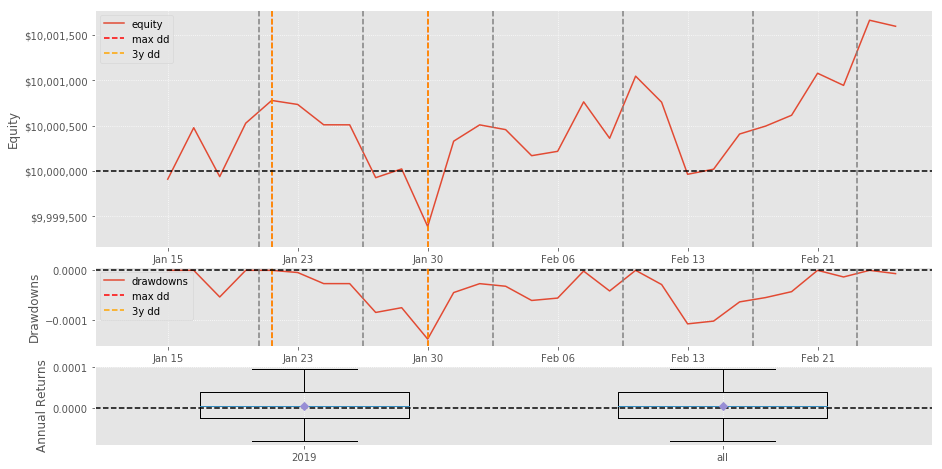

In [6]:
strategy.evaluate_returns();

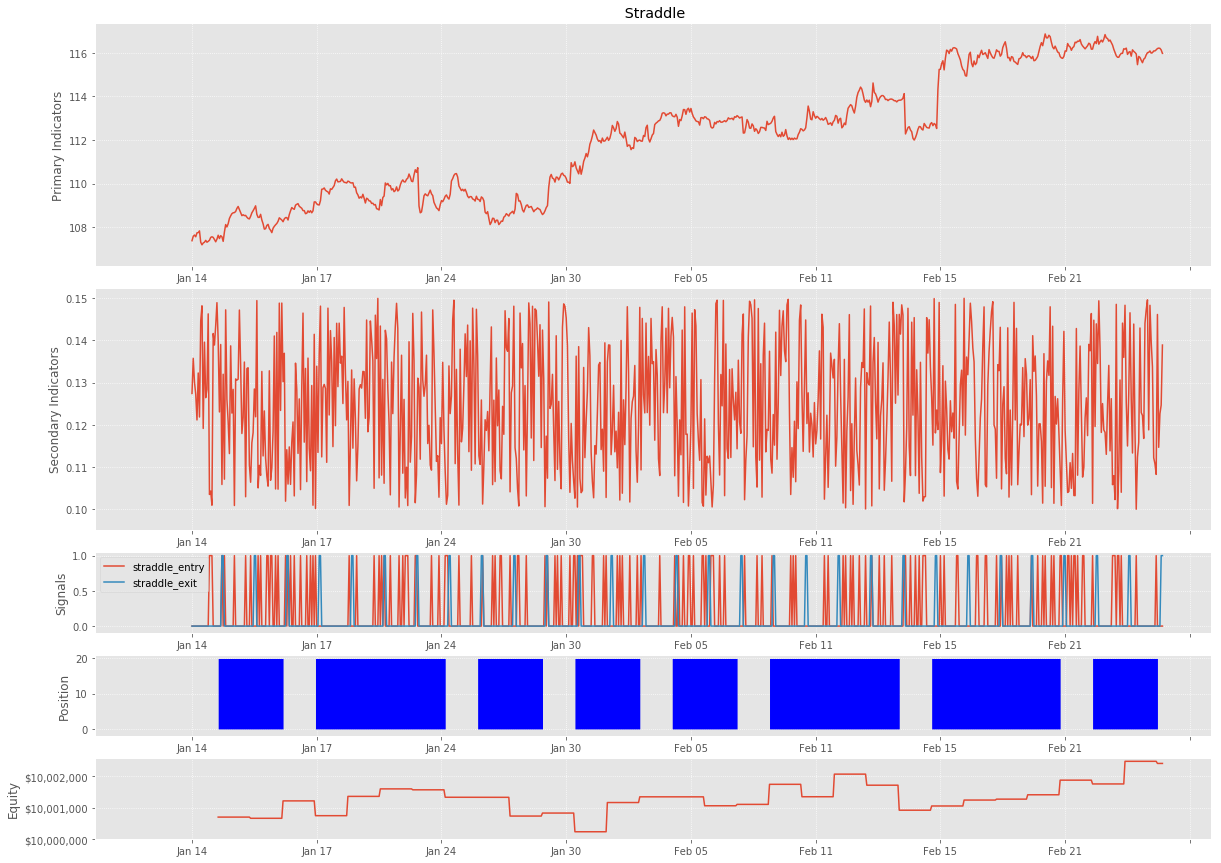

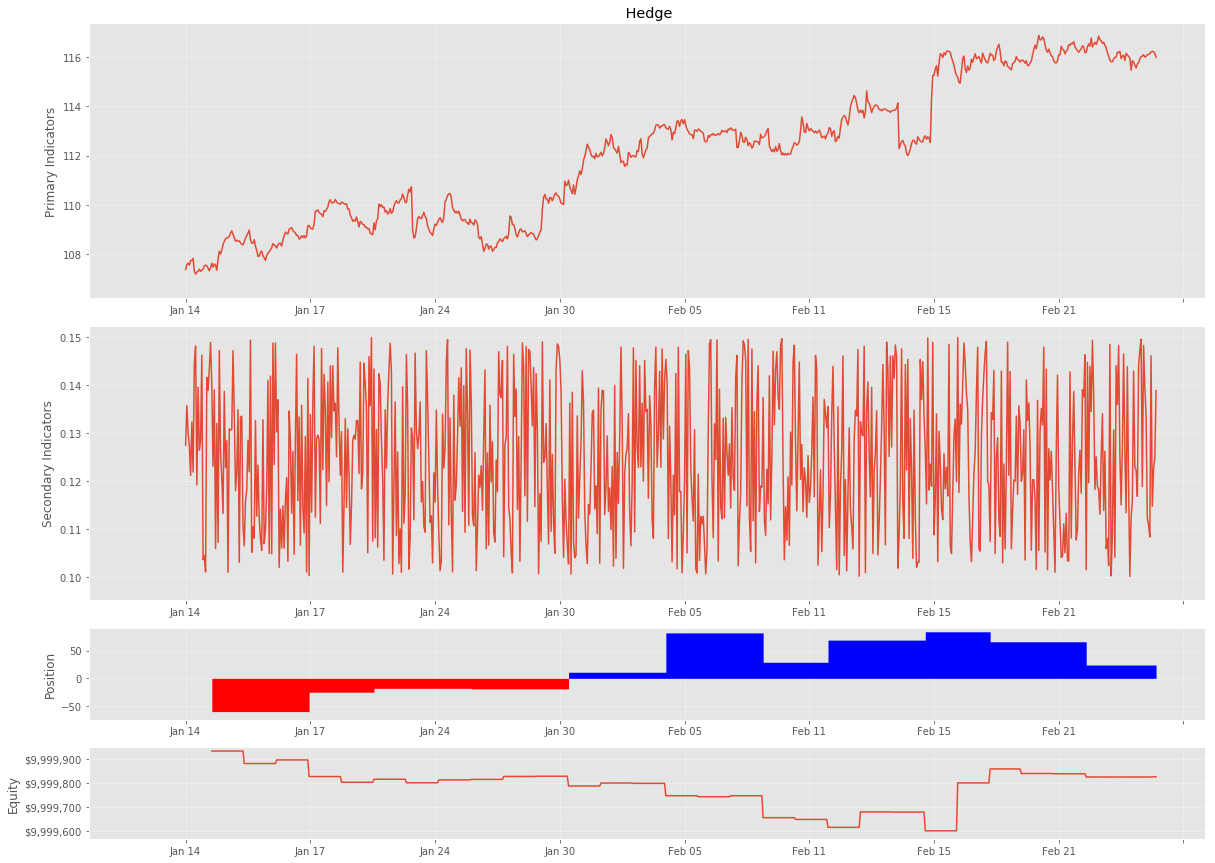

In [7]:
strategy.plot(primary_indicators = ['close_price'], secondary_indicators=['implied_vol'])